In [1]:
"""Fine_tune_TrOCR_on_IAM_Printed_Database_using_Seq2SeqTrainer .ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1fMfmQ3QLaB16DeaGrsdbC5IoKjuYJlqK

<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
"""


'Fine_tune_TrOCR_on_IAM_Printed_Database_using_Seq2SeqTrainer .ipynb\n\nAutomatically generated by Colab.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1fMfmQ3QLaB16DeaGrsdbC5IoKjuYJlqK\n\n<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>\n'

In [2]:
!pip install -q transformers

In [3]:
!pip install -q datasets jiwer

In [4]:
import pandas as pd
import os

In [5]:
dataset_path = "/home/jovyan/ekyc/lintasarta-ekyc-ocr-evo/data/bangkit_gt/newgtdataset.txt"
df = df = pd.read_fwf(dataset_path, header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df.head()

,file_name,text
0,c04-110-00.jpg,9004010101890017
1,c04-110-01.jpg,SURIEDIBUTAR-BUTAR
2,c04-110-02.jpg,KAWIN
3,c04-110-03.jpg,WIRASWASTA
4,c04-110-04.jpg,WNI


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image

In [9]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [10]:
from transformers import TrOCRProcessor

In [11]:
processor = TrOCRProcessor.from_pretrained('model5')
train_dataset = IAMDataset(root_dir='/home/jovyan/ekyc/lintasarta-ekyc-ocr-evo/data/bangkit_gt/image_file/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/home/jovyan/ekyc/lintasarta-ekyc-ocr-evo/data/bangkit_gt/image_file/',
                           df=test_df,
                           processor=processor)

In [12]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 480
Number of validation examples: 120


In [13]:
"""[link text](https:// [link text](https://))Let's verify an example from the training dataset:"""

"[link text](https:// [link text](https://))Let's verify an example from the training dataset:"

In [14]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [15]:
"""We can also check the original image and decode the labels:"""

'We can also check the original image and decode the labels:'

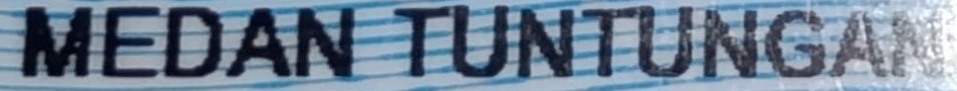

In [16]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [17]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

MEDAN TUNTUNGAN


In [18]:
from transformers import VisionEncoderDecoderModel

In [19]:
model = VisionEncoderDecoderModel.from_pretrained('model5')

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

In [20]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

In [21]:
# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [22]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [23]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    report_to="none",
    eval_strategy="steps",  # Update from 'evaluation_strategy' to 'eval_strategy'
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)


In [24]:
"""We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer))."""

'We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).'

In [25]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [26]:
from evaluate import load

In [27]:
cer_metric = load("cer")

In [28]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [30]:
!pip install wandb
import os
os.environ['WANDB_DISABLED']= "true"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [31]:
from transformers import default_data_collator

In [32]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator, 
)
trainer.train()

Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=180, training_loss=0.5335698925786548, metrics={'train_runtime': 67.5624, 'train_samples_per_second': 21.314, 'train_steps_per_second': 2.664, 'total_flos': 2.131555133643817e+18, 'train_loss': 0.5335698925786548, 'epoch': 3.0})

In [39]:
# Save model and processor
model.save_pretrained('model5')
processor.save_pretrained('model5')

[]

In [ ]:
"""## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.
"""